# Exploring Mental Health Discourse on Reddit (Tokenization, Normalization, and Descriptive Statistics)

This notebook explores textual data extracted from Reddit posts related to mental health. It focuses on preprocessing techniques such as tokenization and normalization to prepare the text for analysis. The goal is to gain a deeper understanding of how mental health topics are discussed on Reddit through comprehensive text analysis.

### Import Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

from textblob import TextBlob

from datasets import load_dataset

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

from collections import Counter
from joblib import Parallel, delayed
from gensim import corpora

import string 
from string import punctuation

import os
import datetime
import time
import re
import requests
import random

import praw

# supress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samantharivas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# import data 
df = pd.read_csv('data/reddit_posts.csv')
mental_health_support_df = pd.read_csv('data/mental_health_support_posts.csv')
mental_health_df = pd.read_csv('data/mental_health_posts.csv')

In [4]:
df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,157,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,158.585859,1.585859,0.003425
1,What changes your negative thoughts/ has made ...,45,0.99,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,45.454545,0.454545,0.000982
2,what is the point of living?,46,0.94,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,48.936170,2.936170,0.001057
3,I need a hug,25,0.95,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,26.315789,1.315789,0.000568
4,What are you like after a hug,23,1.0,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,23.000000,0.000000,0.000497


In [5]:
mental_health_support_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,I feel hopeless.,157,0.99,2024-03-01 11:35:07,"Hi, I’m 24F. I stay home 24/7 , everyday. I do...",MentalHealthSupport,Odd-View-667,False,/r/MentalHealthSupport/comments/1b3s6ad/i_feel...,154.0,158.585859,1.585859,0.003425
1,What changes your negative thoughts/ has made ...,45,0.99,2024-03-03 05:40:38,I am learning that affirmations and the like c...,MentalHealthSupport,Bananasloog1998,False,/r/MentalHealthSupport/comments/1b59lzz/what_c...,21.0,45.454545,0.454545,0.000982
2,what is the point of living?,46,0.94,2024-03-02 04:33:58,\ncontent warning for suicide.\n\n\n\nI dont u...,MentalHealthSupport,penjamincranklin,False,/r/MentalHealthSupport/comments/1b4fkko/what_i...,24.0,48.936170,2.936170,0.001057
3,I need a hug,25,0.95,2024-03-04 12:56:01,I wanna end me.,MentalHealthSupport,Positive-Parthlow,False,/r/MentalHealthSupport/comments/1b6a8vz/i_need...,26.0,26.315789,1.315789,0.000568
4,What are you like after a hug,23,1.0,2024-03-06 15:18:23,If I hug someone I just try my best not to cry...,MentalHealthSupport,itsRileyigitbanned,False,/r/MentalHealthSupport/comments/1b8299d/what_a...,17.0,23.000000,0.000000,0.000497


In [6]:
mental_health_df.head()

,title,score,upvote_ratio,created_utc,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers
0,My daughter is scaring me tonight. No idea how...,929,0.98,2023-12-09 02:50:29,My daughter (10) very suddenly this evening sa...,mentalhealth,ajgl1990,False,/r/mentalhealth/comments/18e3pnh/my_daughter_i...,246,947.959184,18.959184,0.002021
1,Brain cancer at 16… I’m a mess now.,833,0.98,2023-11-10 22:18:46,Became extremely I’ll at 16 and told my mom “t...,mentalhealth,Intelligent_Pipe7980,False,/r/mentalhealth/comments/17sfgi8/brain_cancer_...,88,850.000000,17.000000,0.001812
2,I did it. I graduated. I didn’t let depression...,820,0.99,2023-06-14 15:15:05,Depression took over but I won.,mentalhealth,No_Panic2551,False,/r/mentalhealth/comments/149ah8y/i_did_it_i_gr...,137,828.282828,8.282828,0.001766
3,Date raped and now pregnant and I’m just so sad,727,0.94,2023-11-25 04:06:49,I’ve never been to therapy despite a bunch of ...,mentalhealth,Sensitive_World7780,False,/r/mentalhealth/comments/183b3u5/date_raped_an...,61,773.404255,46.404255,0.001649
4,I killed myself on Monday and feel like I will...,663,0.97,2023-07-02 12:58:41,"I think the title says enough, on Monday I lit...",mentalhealth,Dry_Opportunity8703,False,/r/mentalhealth/comments/14onpo2/i_killed_myse...,127,683.505155,20.505155,0.001457


### Text Preprocessing (Tokenization and Normalization)

In [7]:
# tokenization/normalization 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [8]:
# apply preprocessing to 'selftext'
df['tokens'] = df['selftext'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])

In [24]:
# descriptive statistics
numerical_stats = df.describe()
token_count_stats = df['tokens'].describe()

# most common words
all_tokens = [token for tokens in df['tokens'] for token in tokens]
fdist = FreqDist(all_tokens)
most_common_words = fdist.most_common(10)

# output statistics for combined df 
print("Numerical Statistics:\n", numerical_stats)
print("\nToken Count Statistics:\n", token_count_stats)
print("\nMost Common Words:\n", most_common_words)

Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers  \
count   3942.000000  3942.000000  3942.000000          3942.000000   
mean      17.517757    31.726630     1.511511             0.000095   
std       43.277441    75.544076     4.794466             0.000169   
min        0.000000     0.000000     0.000000             0.000000   
25%        0.000000     1.000000     0.000000             0.000017   
50%        1.500000     2.000000     0.000000             0.000043   
75%       13.000000    34.760426     0.813953             0.000111   
max      616.000000   947.959184    61.205128             0.003425   

             index  
count  2026.000000  
mean   1012.500000  
std     585.000142  
min       0.000000  
25%     506.250000  
50%    1012.500000  
75%    1518.750000  
max    2025.000000  

Token Count Statistics:
 count     3943
unique    3762
top         []
freq         9
Name: tokens, dtype: object

Most Common Words:
 [('like', 6355), ('fee

Based on the descriptive statistics provided, we have opted to analyze each subreddit separately for r/MentalHealth and r/MentalHealthSupport. This approach allows for a more focused exploration of each subreddit's unique trends and characteristics. By focusing individually on each subreddit, we can gain deeper insights into specific trends within each subreddit.

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        return [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    else:
        return []

# apply preprocessing to 'selftext' in both df
mental_health_support_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_support_df['selftext'])
mental_health_df['tokens'] = Parallel(n_jobs=-1)(delayed(preprocess_text)(text) for text in mental_health_df['selftext'])

# function for analyzing subreddits
def analyze_subreddit(subreddit_df):
    numerical_stats = subreddit_df.describe()
    token_count_stats = subreddit_df['tokens'].apply(len).describe()
    all_tokens = [token for tokens in subreddit_df['tokens'] for token in tokens]
    most_common_words = Counter(all_tokens).most_common(10)
    return numerical_stats, token_count_stats, most_common_words

# sentiment analysis functions
def get_sentiment_category(sentiment):
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

def analyze_sentiments(subreddit_df):
    sid = SentimentIntensityAnalyzer()
    subreddit_df['sentiment'] = subreddit_df['selftext'].apply(lambda x: sid.polarity_scores(x) if isinstance(x, str) else {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0})
    subreddit_df['sentiment_category'] = subreddit_df['sentiment'].apply(get_sentiment_category)
    sentiment_stats = subreddit_df['sentiment'].apply(lambda x: x['compound']).describe()
    sentiment_category_counts = subreddit_df['sentiment_category'].value_counts()
    return sentiment_stats, sentiment_category_counts

# function to generate word cloud
def generate_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# topic modeling function
def topic_modeling(tokens_list, num_topics=5):
    dictionary = corpora.Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    topics = lda_model.print_topics(num_words=10)
    return topics

# time series plot function
def plot_time_series(subreddit_df, title):
    subreddit_df['created_utc'] = pd.to_datetime(subreddit_df['created_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    subreddit_df.set_index('created_utc', inplace=True)
    monthly_counts = subreddit_df.resample('M').size()
    monthly_counts.plot(figsize=(10, 5), title=title)
    plt.ylabel('Number of Posts')
    plt.show()

## Descriptive Statistics 

### r/MentalHealthSupport subreddit

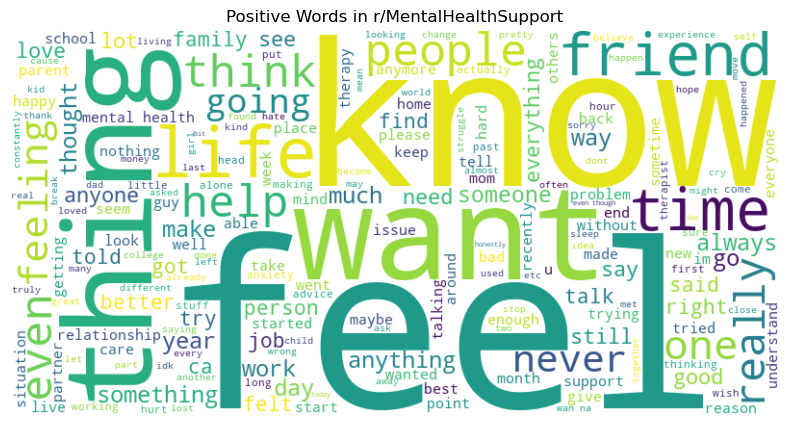

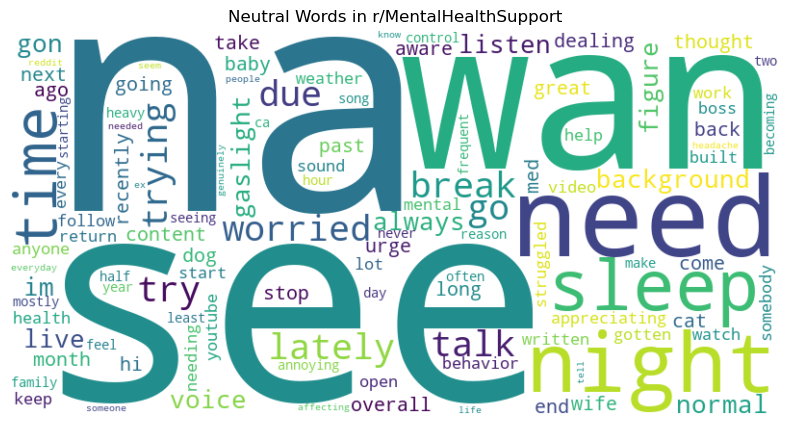

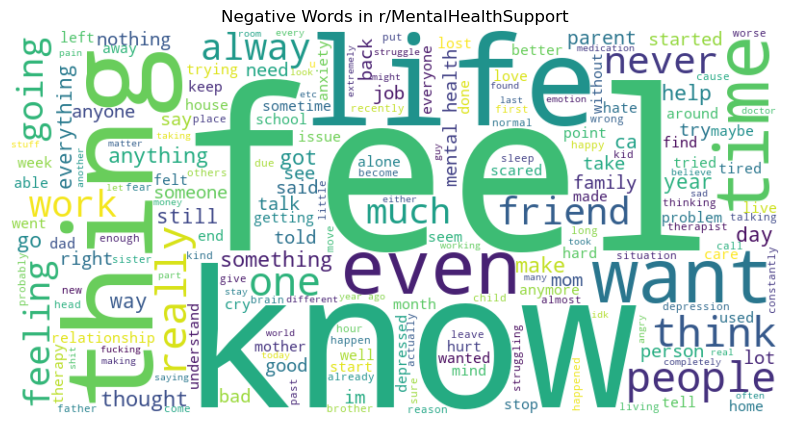

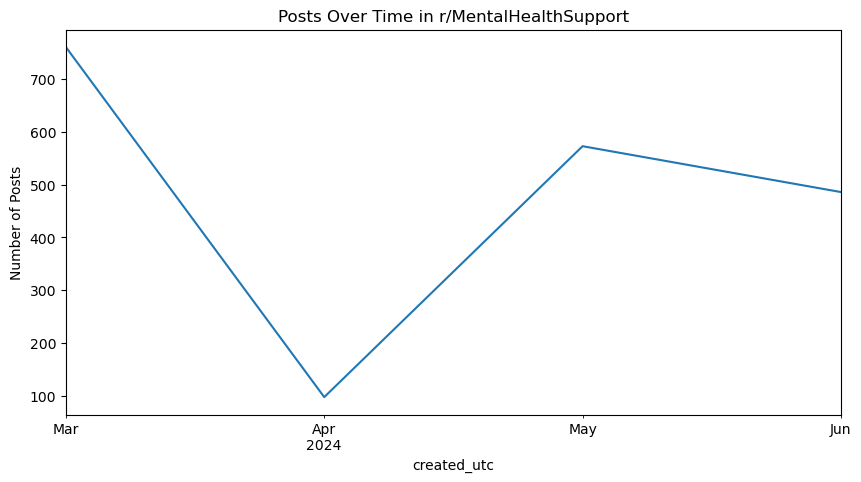


Descriptive Statistics for r/MentalHealthSupport:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers
count   1916.000000  1916.000000  1916.000000          1916.000000
mean       2.150313     2.928661     0.131166             0.000063
std        5.392322     4.875555     0.353119             0.000105
min        0.000000     0.000000     0.000000             0.000000
25%        0.000000     1.000000     0.000000             0.000022
50%        0.000000     2.000000     0.000000             0.000043
75%        2.000000     3.000000     0.000000             0.000065
max      154.000000   158.585859     2.936170             0.003425

Token Count Statistics:
 count    1917.000000
mean      113.455399
std       114.380681
min         0.000000
25%        42.000000
50%        80.000000
75%       142.000000
max      1146.000000
Name: tokens, dtype: float64

Most Common Words:
 [('like', 3607), ('feel', 3310), ('know', 2265), ('time', 1889), ('get', 1873),

In [17]:
# r/MentalHealthSupport subreddit
mental_health_support_numerical_stats, mental_health_support_token_count_stats, mental_health_support_common_words = analyze_subreddit(mental_health_support_df)
mental_health_support_sentiment_stats, mental_health_support_sentiment_category_counts = analyze_sentiments(mental_health_support_df)
mental_health_support_topics = topic_modeling(mental_health_support_df['tokens'].tolist())

# word cloud for r/MentalHealthSupport subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealthSupport")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealthSupport")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealthSupport")

# time series analysis for r/MentalHealthSupport subreddit
mental_health_support_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_support_df, "Posts Over Time in r/MentalHealthSupport")

# statistics for r/MentalHealthSupport subreddit
print("\nDescriptive Statistics for r/MentalHealthSupport:")
print("Numerical Statistics:\n", mental_health_support_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_support_token_count_stats)
print("\nMost Common Words:\n", mental_health_support_common_words)
print("\nSentiment Statistics:\n", mental_health_support_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_support_sentiment_category_counts)

In [21]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_support_df['tokens'], mental_health_support_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['year', 'think', 'sitting', 'feel', 'presence', 'get', 'escape', 'shut', 'getting', 'medication', 'video', 'embarrassed', 'tear', 'support', 'usually', 'like', 'redirect', 'able', 'middle', 'well']

Sampled Neutral Words:
['na', 'end', 'time', 'open', 'talk', 'seeing', 'reason', 'song', 'need', 'background', 'live', 'trying', 'stop', 'figure', 'know', 'struggled', 'becoming', 'start', 'trying', 'people']

Sampled Negative Words:
['never', 'healthy', 'away', 'ability', 'advice', 'growing', 'sign', 'position', 'even', 'tried', 'anxiety', 'life', 'panel', 'telling', 'home', 'people', 'yeah', 'angry', 'quality', 'care']


### r/MentalHealth subreddit

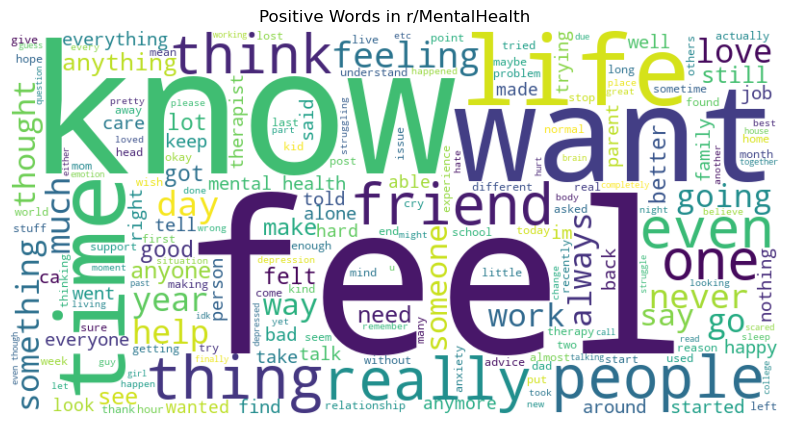

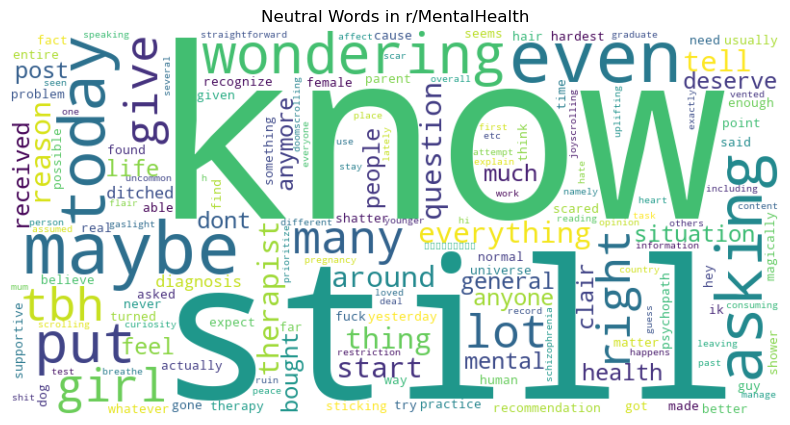

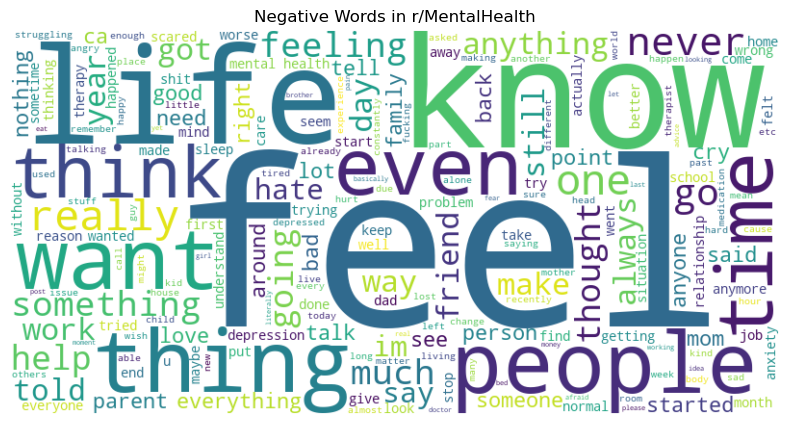

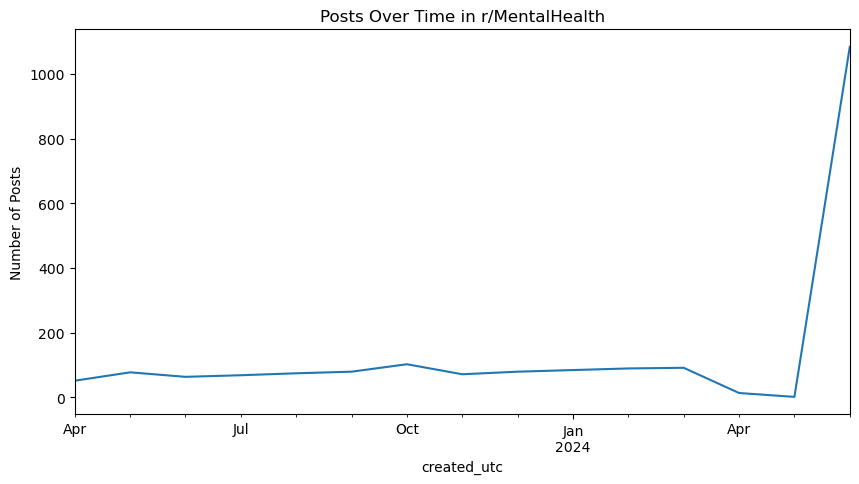


Descriptive Statistics for r/MentalHealth:
Numerical Statistics:
              score  upvote_ratio  num_comments      upvotes    downvotes  \
count  2026.000000   2026.000000   2026.000000  2026.000000  2026.000000   
mean     56.144126      0.953470     32.050839    58.961037     2.816910   
std      93.851082      0.092288     56.416309    97.761885     6.411775   
min       0.000000      0.260000      0.000000     0.000000     0.000000   
25%       1.000000      0.950000      1.000000     1.000000     0.000000   
50%      14.000000      0.990000      8.000000    14.303371     0.010101   
75%      70.000000      1.000000     43.000000    74.170103     2.658602   
max     929.000000      1.000000    616.000000   947.959184    61.205128   

       upvotes/subscribers  
count          2026.000000  
mean              0.000126  
std               0.000208  
min               0.000000  
25%               0.000002  
50%               0.000030  
75%               0.000158  
max             

In [18]:
# r/MentalHealth subreddit
mental_health_numerical_stats, mental_health_token_count_stats, mental_health_common_words = analyze_subreddit(mental_health_df)
mental_health_sentiment_stats, mental_health_sentiment_category_counts = analyze_sentiments(mental_health_df)
mental_health_topics = topic_modeling(mental_health_df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in r/MentalHealth")
generate_word_cloud(neutral_words, "Neutral Words in r/MentalHealth")
generate_word_cloud(negative_words, "Negative Words in r/MentalHealth")

# time series analysis for r/MentalHealth subreddit
mental_health_df.reset_index(inplace=True) #reset index
plot_time_series(mental_health_df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for r/MentalHealth:")
print("Numerical Statistics:\n", mental_health_numerical_stats)
print("\nToken Count Statistics:\n", mental_health_token_count_stats)
print("\nMost Common Words:\n", mental_health_common_words)
print("\nSentiment Statistics:\n", mental_health_sentiment_stats)
print("\nSentiment Category Counts:\n", mental_health_sentiment_category_counts)

In [22]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(mental_health_df['tokens'], mental_health_df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['front', 'relationship', 'find', 'stuff', 'explain', 'anyone', 'waking', 'seeing', 'drop', 'voice', 'asking', 'better', 'day', 'exhausted', 'guy', 'lose', 'alone', 'wish', 'one', 'health']

Sampled Neutral Words:
['even', 'still', 'matter', 'diagnosis', 'scar', 'know', 'cause', 'shatter', 'shower', 'record', 'information', 'explain', 'lately', 'dog', 'deserve', 'today', 'psychopath', 'everything', 'lot', 'know']

Sampled Negative Words:
['really', 'figured', 'associate', 'killing', 'talk', 'attack', 'going', 'around', 'shaking', 'post', 'computer', 'never', 'think', 'difficult', 'nothing', 'already', 'anymore', 'depressed', 'stop', 'alone']


### combined subreddits (r/MentalHealthSupport  and r/MentalHealth)

In [19]:
# combine both df into one
mental_health_support_df.reset_index(inplace=True)
mental_health_df.reset_index(inplace=True)

df = pd.concat([mental_health_support_df, 
                mental_health_df], 
               ignore_index=True)

# save processed dataframes to CSV files
df.to_csv('data/reddit_posts_cleaned.csv', index=False)
mental_health_support_df.to_csv('data/mental_health_support_posts_cleaned.csv', index=False)
mental_health_df.to_csv('data/mental_health_posts_cleaned.csv', index=False)

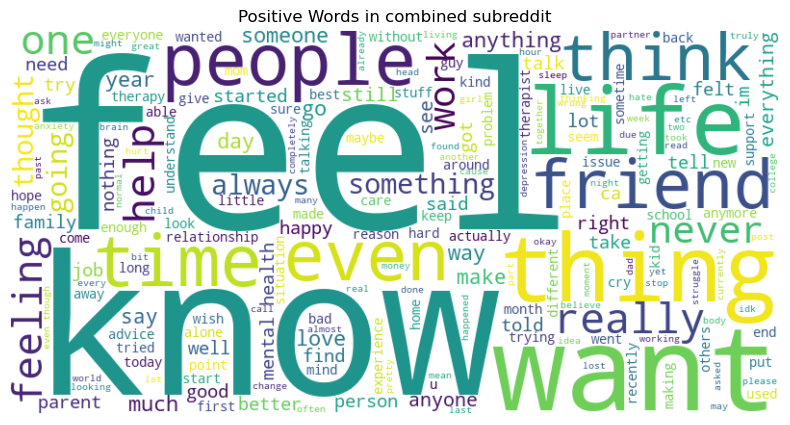

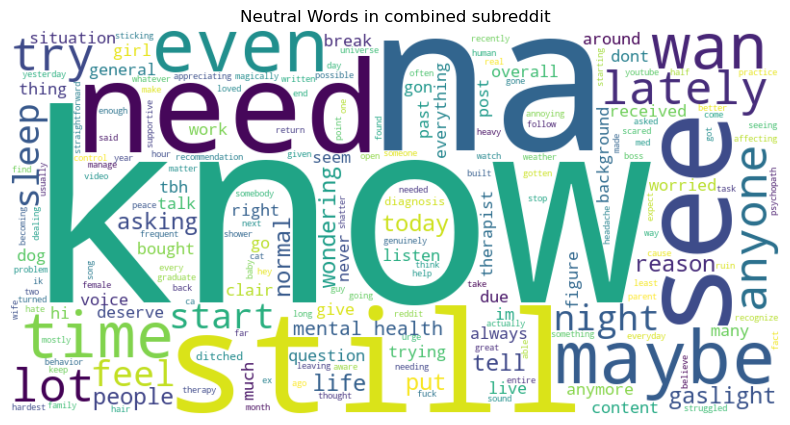

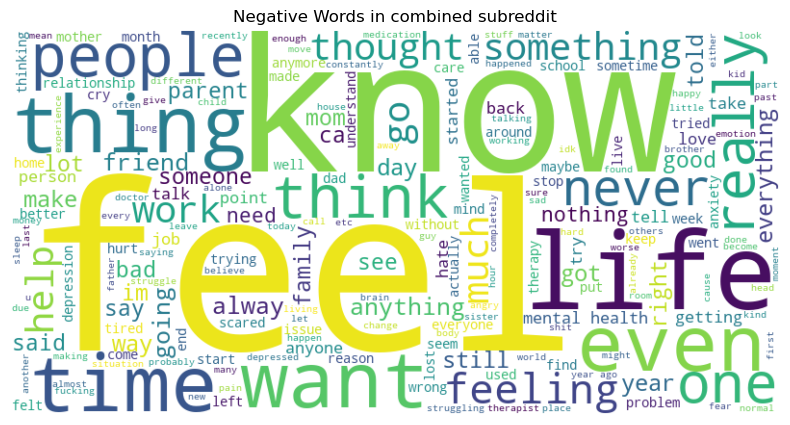

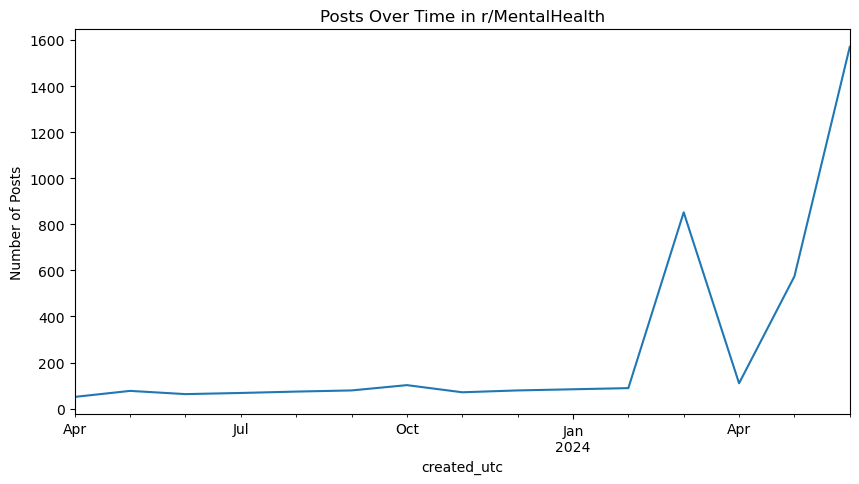


Descriptive Statistics for combined subreddit:
Numerical Statistics:
        num_comments      upvotes    downvotes  upvotes/subscribers  \
count   3942.000000  3942.000000  3942.000000          3942.000000   
mean      17.517757    31.726630     1.511511             0.000095   
std       43.277441    75.544076     4.794466             0.000169   
min        0.000000     0.000000     0.000000             0.000000   
25%        0.000000     1.000000     0.000000             0.000017   
50%        1.500000     2.000000     0.000000             0.000043   
75%       13.000000    34.760426     0.813953             0.000111   
max      616.000000   947.959184    61.205128             0.003425   

             index  
count  2026.000000  
mean   1012.500000  
std     585.000142  
min       0.000000  
25%     506.250000  
50%    1012.500000  
75%    1518.750000  
max    2025.000000  

Token Count Statistics:
 count    3943.000000
mean       95.798630
std        96.059617
min         0.000000

In [20]:
# combined subreddit
df_numerical_stats, df_token_count_stats, df_common_words = analyze_subreddit(df)
df_sentiment_stats, df_sentiment_category_counts = analyze_sentiments(df)
df_topics = topic_modeling(df['tokens'].tolist())

# word cloud for r/MentalHealth subreddit
positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'],df['sentiment_category']) if sentiment == 'negative' for token in tokens]

generate_word_cloud(positive_words, "Positive Words in combined subreddit")
generate_word_cloud(neutral_words, "Neutral Words in combined subreddit")
generate_word_cloud(negative_words, "Negative Words in combined subreddit")

# time series analysis for combined subreddit
plot_time_series(df, "Posts Over Time in r/MentalHealth")

# print statistics for r/MentalHealth subreddit
print("\nDescriptive Statistics for combined subreddit:")
print("Numerical Statistics:\n", df_numerical_stats)
print("\nToken Count Statistics:\n", df_token_count_stats)
print("\nMost Common Words:\n", df_common_words)
print("\nSentiment Statistics:\n", df_sentiment_stats)
print("\nSentiment Category Counts:\n", df_sentiment_category_counts)

In [23]:
# extract common words
sample_size = 20  

positive_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'positive' for token in tokens]
neutral_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'neutral' for token in tokens]
negative_words = [token for tokens, sentiment in zip(df['tokens'], df['sentiment_category']) if sentiment == 'negative' for token in tokens]

positive_sample = random.sample(positive_words, min(len(positive_words), sample_size))
neutral_sample = random.sample(neutral_words, min(len(neutral_words), sample_size))
negative_sample = random.sample(negative_words, min(len(negative_words), sample_size))

print("\nSampled Positive Words:")
print(positive_sample)

print("\nSampled Neutral Words:")
print(neutral_sample)

print("\nSampled Negative Words:")
print(negative_sample)


Sampled Positive Words:
['tend', 'want', 'condition', 'around', 'whether', 'lot', 'way', 'mind', 'much', 'kid', 'actually', 'point', 'people', 'simple', 'stay', 'partner', 'went', 'event', 'know', 'father']

Sampled Neutral Words:
['know', 'know', 'breathe', 'whatever', 'curiosity', 'joyscrolling', 'therapy', 'guy', 'needed', 'everything', 'try', 'time', 'boss', 'still', 'hi', 'else', 'normal', 'least', 'health', 'far']

Sampled Negative Words:
['suffering', 'tell', 'spoiled', 'uglier', 'grocery', 'therapy', 'better', 'damaging', 'forever', 'na', 'completely', 'control', 'time', 'die', 'studying', 'anymore', 'one', 'bicycle', 'anymore', 'really']


In [25]:
df.sample(10)

,title,score,upvote_ratio,selftext,subreddit,author,media_only,permalink,num_comments,upvotes,downvotes,upvotes/subscribers,tokens,sentiment,sentiment_category,index
created_utc,,,,,,,,,,,,,,,,
2024-06-14 19:41:42,I need guidance,1,1.0,I have been dealing with depression for about ...,mentalhealth,Typical-Situation-81,False,/r/mentalhealth/comments/1dfzdf0/i_need_guidance/,2.0,1.000000,0.000000,0.000002,"[dealing, depression, year, diagnosed, stopped...","{'neg': 0.236, 'neu': 0.657, 'pos': 0.107, 'co...",negative,1535.0
2024-03-22 17:01:55,First Heartbreak. Been super depressed. What d...,3,1.0,I know I wrote a lot but if you could help me ...,MentalHealthSupport,JLD082106,False,/r/MentalHealthSupport/comments/1bl488t/first_...,7.0,3.000000,0.000000,0.000065,"[know, wrote, lot, could, help, give, advice, ...","{'neg': 0.086, 'neu': 0.717, 'pos': 0.198, 'co...",positive,NaN
2024-05-22 00:33:09,BPD,1,1.0,I’m sooooo tired of having borderline. I’m tir...,MentalHealthSupport,East_Report3704,False,/r/MentalHealthSupport/comments/1cxndrh/bpd/,0.0,1.000000,0.000000,0.000022,"[sooooo, tired, borderline, tired, anxiety, ti...","{'neg': 0.241, 'neu': 0.695, 'pos': 0.063, 'co...",negative,NaN
2023-11-14 07:10:25,i get hurt even from reddit downvotes,71,0.76,if my comment is even one minus karma I feel h...,mentalhealth,Spam_mayo,False,/r/mentalhealth/comments/17uwtiq/i_get_hurt_ev...,36.0,93.421053,22.421053,0.000199,"[comment, even, one, minus, karma, feel, hurt,...","{'neg': 0.348, 'neu': 0.517, 'pos': 0.135, 'co...",negative,484.0
2024-06-14 01:44:29,I just need a shoulder to cry on Ig,1,1.0,"I've gotten out of a 5 year relationship, and ...",mentalhealth,boogaze,False,/r/mentalhealth/comments/1dffhzq/i_just_need_a...,0.0,1.000000,0.000000,0.000002,"[gotten, year, relationship, taught, lot, trul...","{'neg': 0.163, 'neu': 0.597, 'pos': 0.24, 'com...",positive,1698.0
2024-06-13 20:27:18,Anti anxiety medication?,1,1.0,Was wondering if anyone could share anything a...,mentalhealth,134340summer,False,/r/mentalhealth/comments/1df8tnz/anti_anxiety_...,0.0,1.000000,0.000000,0.000002,"[wondering, anyone, could, share, anything, ge...","{'neg': 0.187, 'neu': 0.691, 'pos': 0.121, 'co...",negative,1747.0
2024-03-14 05:29:54,What the hell is wrong?,2,1.0,every day I wake up and just run through life ...,MentalHealthSupport,None,False,/r/MentalHealthSupport/comments/1bedt3o/what_t...,0.0,2.000000,0.000000,0.000043,"[every, day, wake, run, life, autopilot, idk, ...","{'neg': 0.143, 'neu': 0.787, 'pos': 0.069, 'co...",negative,NaN
2023-12-08 13:54:10,I'M A YEAR FREE FROM SUICIDAL THOUGHTS,218,0.99,Like i know it doesn't really mean anything to...,mentalhealth,None,False,/r/mentalhealth/comments/18dnb8z/im_a_year_fre...,60.0,220.202020,2.202020,0.000469,"[like, know, really, mean, anything, anyone, f...","{'neg': 0.167, 'neu': 0.603, 'pos': 0.229, 'co...",positive,104.0
2024-06-15 14:30:01,"In Japan, many girls with self-harm scars have...",0,0.5,"Or maybe it’s even uncommon , girls with scars...",mentalhealth,Shoplifting_uglydog,False,/r/mentalhealth/comments/1dgj7wb/in_japan_many...,2.0,0.000000,0.000000,0.000000,"[maybe, even, uncommon, girl, scar, country]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1358.0
